In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
import warnings

In [3]:
df = pd.read_csv('data/stud.csv')

In [4]:
df.head(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
df['race_ethnicity'] = df['race_ethnicity'].str.split(' ').str[1]
df['parental_level_of_education'] = df['parental_level_of_education'].str.split(' ').str[0]
df['parental_level_of_education'] = df['parental_level_of_education'].str.split("'").str[0]

df.columns = ['Gender', 'Race', 'Parental_Education', 'Lunch', 'Prep_Course', 'Math', 'Reading', 'Writing']

df['Prep_Course'] = df['Prep_Course'].apply(lambda x: 0 if x== 'none' else 1)

In [6]:
df.head()

,Gender,Race,Parental_Education,Lunch,Prep_Course,Math,Reading,Writing
0,female,B,bachelor,standard,0,72,72,74
1,female,C,some,standard,1,69,90,88
2,female,B,master,standard,0,90,95,93
3,male,A,associate,free/reduced,0,47,57,44
4,male,C,some,standard,0,76,78,75


### Test for correlation between features

<Axes: >

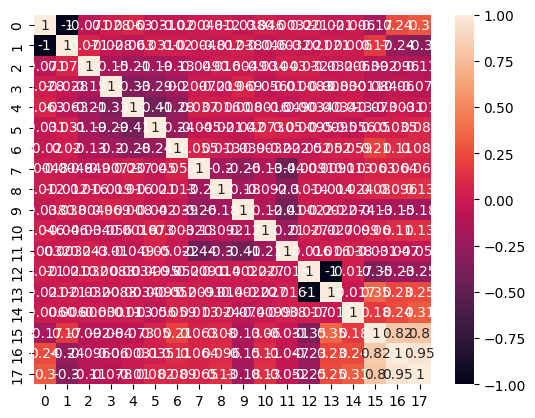

In [7]:
cat_features1 = df.select_dtypes(include = 'object').columns
num_features2 = df.select_dtypes(exclude = 'object').columns

scaler = StandardScaler()
encoder = OneHotEncoder()

trans = ColumnTransformer(
    [
        ('OneHotEncoder', encoder, cat_features1),
        ('StandardScaler', scaler, num_features2)
    ]
)

df_corr = pd.DataFrame(trans.fit_transform(df))

sns.heatmap(df_corr.corr(), annot= True)

<Figure size 800x300 with 0 Axes>

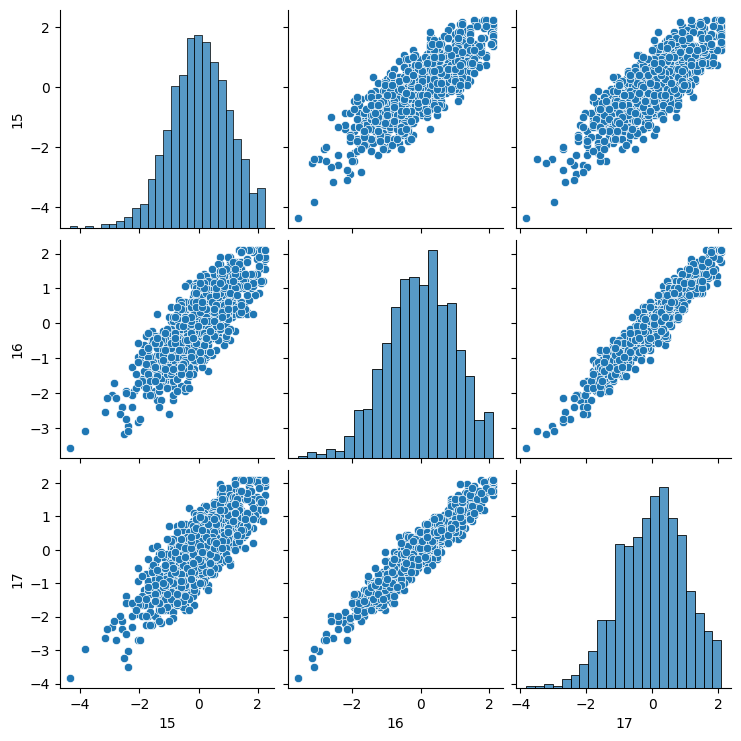

In [19]:
#We can also draw a pairplot that shows the relationship between variables

#First we need to delete columns extracted by OneHotEncoder
df_2 = df_corr.loc[:, df_corr.nunique() > 2]

plt.figure(figsize = (8, 3))
sns.pairplot(df_2)
plt.show()

From this we can see a very high collinearity between the math score and the other scores, which is understandable

#### Split train and test

In [9]:
X = df.drop(['Math'], axis = 1)
y = df[['Math']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Create ColumnTransformer to encode and scale the data

In [10]:
cat_features = X.select_dtypes(include = 'object').columns
num_features = X.select_dtypes(exclude = 'object').columns

scaler = StandardScaler()
encoder = OneHotEncoder()

ct = ColumnTransformer(
    [
        ('OneHotEncoder', encoder, cat_features),
        ('StandardScaler', scaler, num_features)
    ]
)

In [11]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [12]:
#Create Evaluation function for models
def evaluate_model(test, pred):
    r2_square = r2_score(test, pred)
    mape = mean_absolute_error(test, pred)
    rmse = np.sqrt(mean_squared_error(test, pred))
    
    print(f'R2: {r2_square}\nMAE: {mape}\nRMSE: {rmse}')
    
    return r2_square

#### Hyperparameter Tuning

In [13]:
#Hyperparameter tuning for each model

params = {
    'params_tree' : {
        'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'splitter': ['best', 'random'],
        'max_depth': [5, 8, 10],
        'min_samples_split': [2, 5, 8],
        'max_depth': ['None', 5, 8, 10]
    },

    'params_forest' : {
        'max_depth':[5, 8, 10, None],
        'max_features':[5, 7, 'auto', 8],
        'min_samples_split':[2, 8, 15],
        'n_estimators': [100, 200, 300, 400]
    },
    
    'params_KNN': {
        'n_neighbors': [5, 8, 10, 15, 30]
    },
    
    'params_Ada': {
        'n_estimators': [100, 200, 300, 400]
    },
    
    'params_SVR': {
        'C': [1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }
}

models_params = {
    "DecisionTree": (DecisionTreeRegressor(), params["params_tree"]),
    "RandomForest": (RandomForestRegressor(), params["params_forest"]),
    'KNeighborsRegressor': (KNeighborsRegressor(), params['params_KNN']),
    'AdaBoost': (AdaBoostRegressor(), params['params_Ada']),
    'SupportVectorRegressor': (SVR(), params['params_SVR'])
}

def tuning(X_train, y_train):
    best_params = {}
    for model_name, (model, param_grid) in models_params.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        best_params[model_name] = grid_search.best_params_
        print(f"Best params for {model_name}: {grid_search.best_params_}")


In [14]:
# tuning(X_train, y_train)

#### Fitting the models

In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=15, n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=2, splitter='best'),
    "Random Forest Regressor": RandomForestRegressor(max_depth=None, max_features=8, min_samples_split=8, n_estimators=400),
    "XGBRegressor": XGBRegressor(), 
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=400),
    'Support Vector Regressor': SVR(kernel = 'linear')
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    
    print(list(models.keys())[i])
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset

    r2 = evaluate_model(y_test, y_test_pred)
    r2_list.append(r2)
    
    

    model_list.append(list(models.keys())[i])
    print('='*35)

Linear Regression
R2: 0.8807862302124223
MAE: 4.206291597375163
RMSE: 5.386027107068575
Lasso
R2: 0.8254456303262371
MAE: 5.155716783641633
RMSE: 6.517344630247966
Ridge
R2: 0.8809831828751378
MAE: 4.202521259042154
RMSE: 5.381576149443264
K-Neighbors Regressor
R2: 0.7986901277306737
MAE: 5.397666666666667
RMSE: 6.999030091535699
Decision Tree
R2: 0.8242299188020519
MAE: 4.931523210662771
RMSE: 6.540000789493743
Random Forest Regressor


d:\Study\Education\Projects\Udemy Project 1\project1\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R2: 0.8510269529890583
MAE: 4.604505817289867
RMSE: 6.020868949144079
XGBRegressor
R2: 0.8267024159431458
MAE: 5.043186187744141
RMSE: 6.493839866155878
AdaBoost Regressor


d:\Study\Education\Projects\Udemy Project 1\project1\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2: 0.8485057531739697
MAE: 4.749321402700329
RMSE: 6.071603382291312
Support Vector Regressor
R2: 0.8813338371027841
MAE: 4.2159338495787075
RMSE: 5.373642546127149


d:\Study\Education\Projects\Udemy Project 1\project1\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Show the efficiency of each model

In [16]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False).reset_index()

,index,Model Name,R2_Score
0,8,Support Vector Regressor,0.881334
1,2,Ridge,0.880983
2,0,Linear Regression,0.880786
3,5,Random Forest Regressor,0.851027
4,7,AdaBoost Regressor,0.848506
5,6,XGBRegressor,0.826702
6,1,Lasso,0.825446
7,4,Decision Tree,0.824230
8,3,K-Neighbors Regressor,0.798690
